# Trading Strategies powered by Machine Learning - Random Forest Classifier

## Random Forest Classifier with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
from backtesting import Strategy
from sklearn.ensemble import RandomForestClassifier

## Getting the Data

In [4]:
XAUUSD = load_data()

In [5]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [6]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


## ML

### Class and Strategy ML

In [7]:
class Random_Forest_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [8]:
strategy = Random_Forest_Classifier
account_size = 10000
folder_ML_Strategy = 'Random Forest Classifier'

In [9]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
from util.ATR import *
from util.SMA import *
from util.RSI import *
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_RFC():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def get_rsi(self, df, rsi_period):
        chg = df['Close'].diff(1)
        gain = chg.mask(chg < 0, 0)
        loss = chg.mask(chg > 0, 0)
        avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        rs = abs(avg_gain/avg_loss)
        rsi = 100 - (100/(1+rs))
        return rsi

    def Create_Features(self):

        df = self.data.copy()

        # relative strength index
        df['rsi14'] = self.get_rsi(df, 14)
        df['ATR'] = ATR(df, 20)['ATR']

        periods = 14
        moving_av = 3

        df["roll_low"] = df['Low'].rolling(periods).min()
        df["roll_high"] = df['High'].rolling(periods).max()
        df["K"] = (df.Close - df.roll_low) / (df.roll_high - df.roll_low) * 100
        df["D"] = df.K.rolling(moving_av).mean()

        df = df.drop('roll_low', axis=1)
        df = df.drop('roll_high', axis=1)

        self.data = df

    def Add_Signal(self):

        df = self.data.copy()
        df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))
        df['signal_t1'] = np.sign(df.returns)
        df['signal'] = df.signal_t1.shift(-1)
        df = df.drop(columns=['returns', 'signal_t1'])
        df = df.dropna()

        self.data = df

    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        y_train = self.data_train['signal'].copy()
        x_train = self.data_train.drop(columns=['signal'])
        x_test = self.data_test.drop(columns=['signal'])

        self.model = RandomForestClassifier()
        self.model.fit(x_train, y_train)

        # Make predictions
        self.data_train['pred'] = self.model.predict(x_train)
        self.data_test['pred'] = self.model.predict(x_test)

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [10]:
ML_Class = ML_RFC

## TF D1

In [11]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [12]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [13]:
train, test = ml.Run()

### In-Sample Backtesting

In [14]:
train

Start                     2007-01-24 00:00:00
End                       2019-12-31 00:00:00
Duration                   4724 days 00:00:00
Exposure Time [%]                   99.950397
Equity Final [$]                 41340.114631
Equity Peak [$]                  41340.121631
Return [%]                         313.401146
Buy & Hold Return [%]              134.605201
Return (Ann.) [%]                    9.275608
Volatility (Ann.) [%]                0.819298
Sharpe Ratio                        11.321404
Sortino Ratio                      241.347367
Calmar Ratio                       164.900809
Max. Drawdown [%]                    -0.05625
Avg. Drawdown [%]                   -0.006831
Max. Drawdown Duration        6 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                 2077
Win Rate [%]                        96.918633
Best Trade [%]                      15.822334
Worst Trade [%]                     -0.795939
Avg. Trade [%]                    

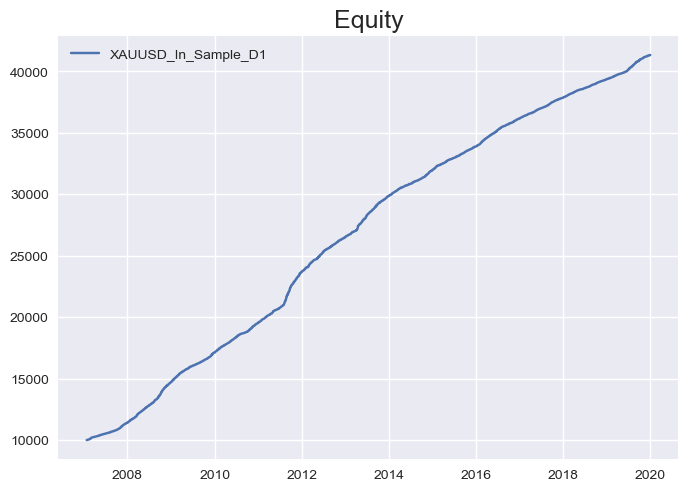

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                  9730.934694
Equity Peak [$]                  10066.289269
Return [%]                          -2.690653
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                   -0.691872
Volatility (Ann.) [%]                2.712838
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -7.302771
Avg. Drawdown [%]                   -4.013206
Max. Drawdown Duration     1128 days 00:00:00
Avg. Drawdown Duration      579 days 00:00:00
# Trades                                  238
Win Rate [%]                        52.521008
Best Trade [%]                       5.804967
Worst Trade [%]                     -7.582454
Avg. Trade [%]                    

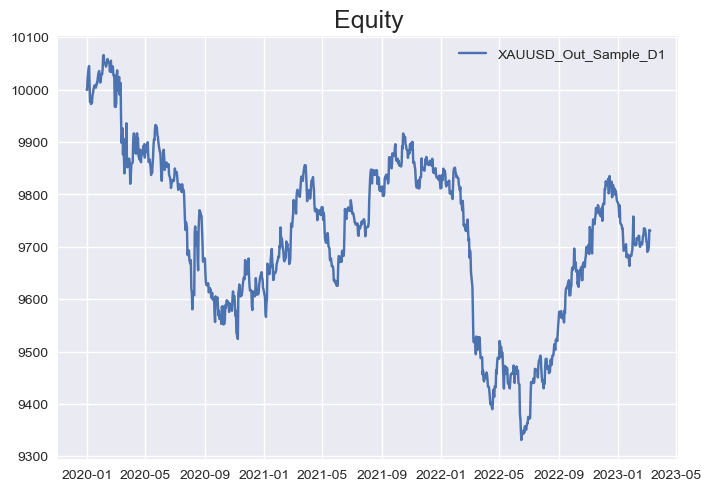

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [18]:
filename_train = f'result_{TF}_In_Sample.csv'

In [19]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [20]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [21]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [22]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [23]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [24]:
train, test = ml.Run()

### In-Sample Backtesting

In [25]:
train

Start                     2007-01-04 08:00:00
End                       2019-12-31 20:00:00
Duration                   4744 days 12:00:00
Exposure Time [%]                   99.990408
Equity Final [$]                 74696.449301
Equity Peak [$]                  74699.539239
Return [%]                         646.964493
Buy & Hold Return [%]              141.990881
Return (Ann.) [%]                     13.3259
Volatility (Ann.) [%]                1.010954
Sharpe Ratio                        13.181512
Sortino Ratio                      526.711509
Calmar Ratio                        275.08574
Max. Drawdown [%]                   -0.048443
Avg. Drawdown [%]                   -0.001529
Max. Drawdown Duration        4 days 08:00:00
Avg. Drawdown Duration        0 days 19:00:00
# Trades                                10739
Win Rate [%]                        95.344073
Best Trade [%]                       11.36876
Worst Trade [%]                     -0.781987
Avg. Trade [%]                    

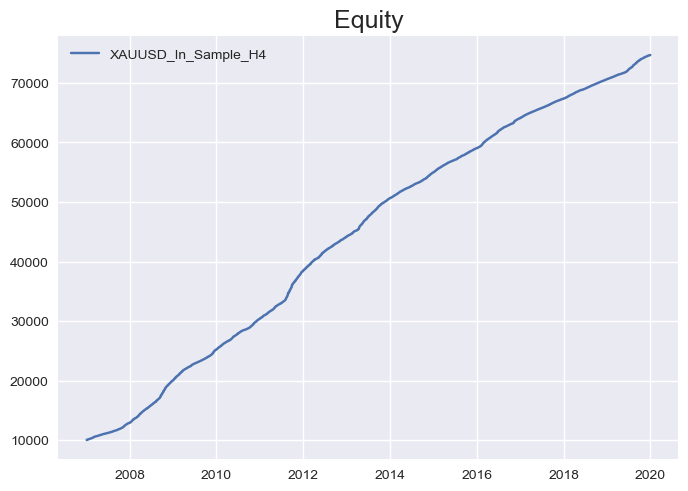

In [26]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [27]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                  9363.602031
Equity Peak [$]                  10083.582583
Return [%]                           -6.36398
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                   -1.658174
Volatility (Ann.) [%]                2.833604
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.204267
Avg. Drawdown [%]                   -1.589487
Max. Drawdown Duration     1156 days 08:00:00
Avg. Drawdown Duration      193 days 16:00:00
# Trades                                 1801
Win Rate [%]                        47.418101
Best Trade [%]                       4.305149
Worst Trade [%]                     -6.196276
Avg. Trade [%]                    

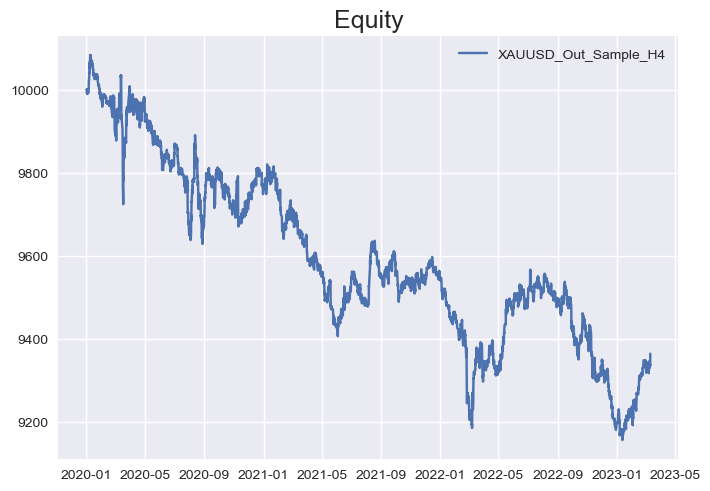

In [28]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [29]:
filename_train = f'result_{TF}_In_Sample.csv'

In [30]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [11]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [12]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [13]:
train, test = ml.Run()

### In-Sample Backtesting

In [14]:
train

Start                     2007-01-01 20:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 01:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                128382.709576
Equity Peak [$]                 128383.796116
Return [%]                        1183.827096
Buy & Hold Return [%]              138.603939
Return (Ann.) [%]                   17.203869
Volatility (Ann.) [%]                1.397484
Sharpe Ratio                        12.310599
Sortino Ratio                     1239.776329
Calmar Ratio                        494.47086
Max. Drawdown [%]                   -0.034792
Avg. Drawdown [%]                   -0.000859
Max. Drawdown Duration        3 days 16:00:00
Avg. Drawdown Duration        0 days 05:00:00
# Trades                                41571
Win Rate [%]                        91.251113
Best Trade [%]                      10.914605
Worst Trade [%]                     -0.950574
Avg. Trade [%]                    

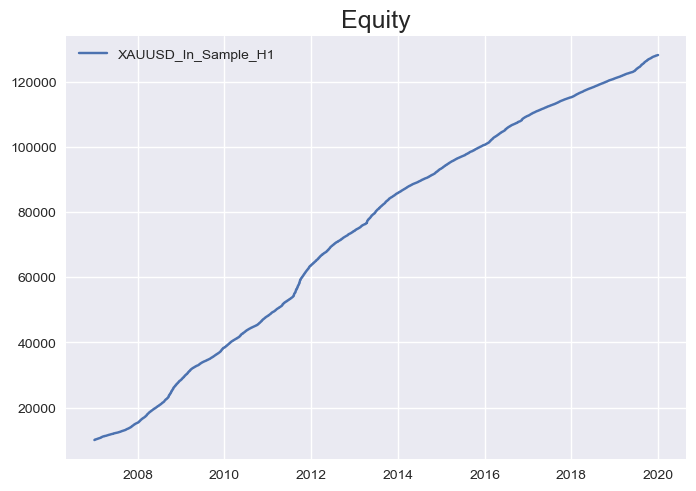

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                  7897.614215
Equity Peak [$]                  10000.456279
Return [%]                         -21.023858
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                   -5.825271
Volatility (Ann.) [%]                2.814567
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -21.288276
Avg. Drawdown [%]                  -21.288276
Max. Drawdown Duration     1163 days 15:00:00
Avg. Drawdown Duration     1163 days 15:00:00
# Trades                                 6697
Win Rate [%]                        50.261311
Best Trade [%]                       3.966908
Worst Trade [%]                     -4.000468
Avg. Trade [%]                    

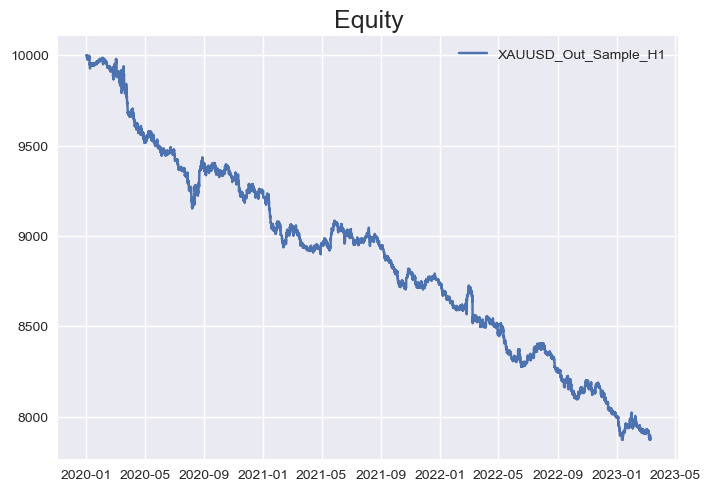

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [18]:
filename_train = f'result_{TF}_In_Sample.csv'

In [19]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [11]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [12]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [13]:
train, test = ml.Run()

### In-Sample Backtesting

In [14]:
train

Start                     2007-01-01 10:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 11:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                170147.886982
Equity Peak [$]                 170148.910513
Return [%]                         1601.47887
Buy & Hold Return [%]              138.590804
Return (Ann.) [%]                   19.275319
Volatility (Ann.) [%]                1.657533
Sharpe Ratio                        11.628922
Sortino Ratio                     1987.388526
Calmar Ratio                       476.891935
Max. Drawdown [%]                   -0.040419
Avg. Drawdown [%]                    -0.00065
Max. Drawdown Duration        3 days 11:00:00
Avg. Drawdown Duration        0 days 02:29:00
# Trades                                82664
Win Rate [%]                        88.115746
Best Trade [%]                       8.092709
Worst Trade [%]                     -0.982087
Avg. Trade [%]                    

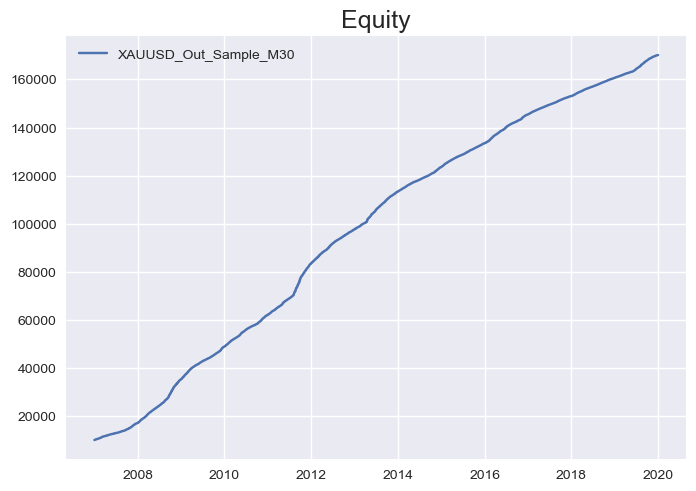

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                  5838.565231
Equity Peak [$]                  10000.195508
Return [%]                         -41.614348
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                  -12.788388
Volatility (Ann.) [%]                2.850789
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -42.057875
Avg. Drawdown [%]                  -21.067311
Max. Drawdown Duration     1163 days 02:30:00
Avg. Drawdown Duration      581 days 20:45:00
# Trades                                14105
Win Rate [%]                        49.103155
Best Trade [%]                       3.783868
Worst Trade [%]                     -4.720538
Avg. Trade [%]                    

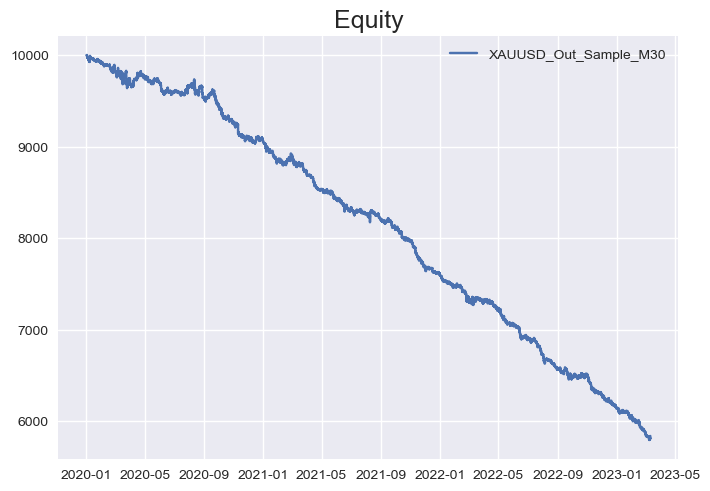

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [18]:
filename_train = f'result_{TF}_In_Sample.csv'

In [19]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [ ]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')